In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../../SyMBac')
sys.path.insert(1, '../../single_cell_projection_diffraction/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from matplotlib.colors import LogNorm, AsinhNorm, PowerNorm
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.renderer import convolve_rescale, PSF_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import cupy as cp
from cupyx.scipy.ndimage import convolve as cuconvolve
def convolve_rescale(image, kernel, rescale_factor, rescale_int):
    """
    Convolves an image with a kernel, and rescales it to the correct size.

    Parameters
    ----------
    image : 2D numpy array
        The image
    kernel : 2D numpy array
        The kernel
    rescale_factor : int
        Typicall 1/resize_amount. So 1/3 will scale the image down by a factor of 3. We do this because we render the image and kernel at high resolution, so that we can do the convolution at high resolution.
    rescale_int : bool
        If True, rescale the intensities between 0 and 1 and return a float32 numpy array of the convolved downscaled image.

    Returns
    -------
    outupt : 2D numpy array
        The output of the convolution rescale operation
    """

    output = cuconvolve(cp.array(image), cp.array(kernel),mode="constant")
    output = output.get()
    output = rescale(output, rescale_factor, anti_aliasing=False)

    if rescale_int:
        output = rescale_intensity(output.astype(np.float32), out_range=(0, 1))
    return output

In [3]:
def crop_to_size(arr, x, y):
    crop_x = arr.shape[1] - x
    crop_y = arr.shape[0] - y
    return arr[crop_y//2:-crop_y//2, crop_x//2:-crop_x//2]

In [4]:
real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
real_PSF = real_PSF[:,100:-100,100:-100]
original_z = real_PSF.shape[0]
real_PSF = real_PSF[(original_z - 41)//2:-(original_z - 41)//2]

real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF -= real_PSF.min()
real_PSF = np.clip(real_PSF, 0, np.inf)
real_PSF = real_PSF / real_PSF.max()
real_PSF.shape

(41, 41, 41)

In [5]:
def get_real_PSF(PSF_size_xyz):
    pix_mic_conv = 0.05
    real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
    real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
    #real_PSF = gaussian(real_PSF, sigma = 0.75)
    midpoint_xy = real_PSF.shape[1]//2
    midpoint_z = real_PSF.shape[0]//2
    
    original_z = real_PSF.shape[0]
    original_xy = real_PSF.shape[1]
    
    max_intensities = real_PSF.max(axis=(1,2))
    peak_intensity_z =  np.argwhere(max_intensities == np.max(max_intensities))[0][0]
    
    
    real_PSF = real_PSF[
        midpoint_z - PSF_size_xyz//2:midpoint_z + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1
    ]
    
    
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
    real_PSF = np.clip(real_PSF, 0, np.inf)
    real_PSF = real_PSF / real_PSF.max()
    return real_PSF

In [6]:
real_PSF = get_real_PSF(41)

In [7]:
def lorentzian_2d_DoG(amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    lorentz =  amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2) + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset * 10
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    DoG = DoG
    return lorentz * DoG 



In [8]:
good_fit = [2.207e+00, 2.467e+01 - 4.5, 2.441e+01 - 4.5, 3.893e+00, 3.846e+00, 1.970e+00, 1.326e+00, 6.674e-03, 6.375e-01, 2.458e-01]

x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = xdata_tuple = np.meshgrid(x, y)

lorentz_PSF_2d = lorentzian_2d_DoG(*good_fit, xdata_tuple)

In [9]:
pix_mic_conreal_PSF = 0.05

In [10]:
pix_mic_conv = 0.05

In [11]:
my_kernel_xy = tifffile.imread("../PSF_fitted_for_single_molecule_50nm_pix_xy_only_.tif")
my_kernel_xyz = tifffile.imread("../PSF_fitted_for_single_molecule_50nm_pix_xyz.tif")
import pickle
with open('../PSF_fitted_for_single_molecule_50nm_pix_xy_only_params.pkl', 'rb') as f:
    good_fit = pickle.load(f).x # deserialize using load()

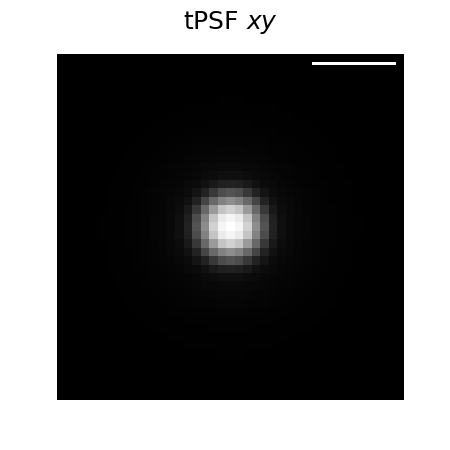

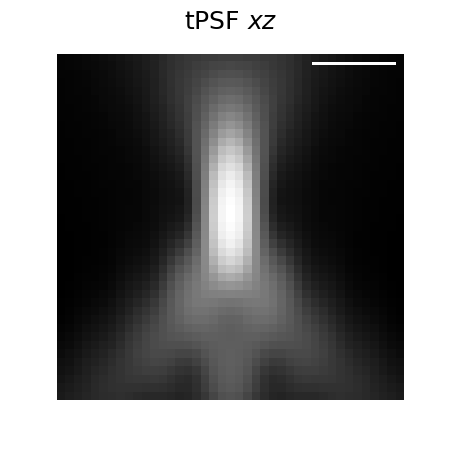

In [12]:
fig, axs = plt.subplots(1,1, figsize=(1.5, 1.5), dpi = 300)
plt.imshow(my_kernel_xy[0], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("tPSF $x y$")

plt.savefig("synth_kernel_xy.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1.5, 1.5), dpi = 300)
plt.imshow(my_kernel_xyz.sum(axis=1), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("tPSF $x z$")

plt.savefig("synth_kernel_xz.svg")
plt.show()


In [13]:
lorentz_PSF_3d = tifffile.imread("../ePSF_fitted_50nm_pix_xyz.tif").sum(axis=0)

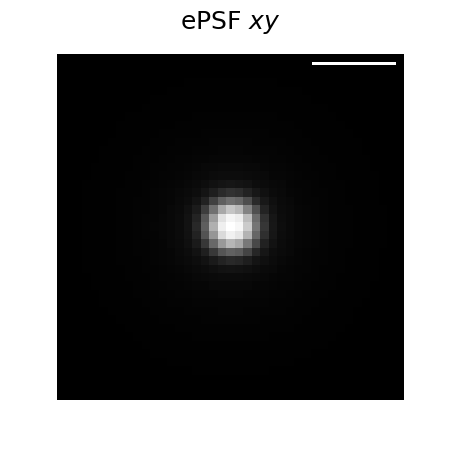

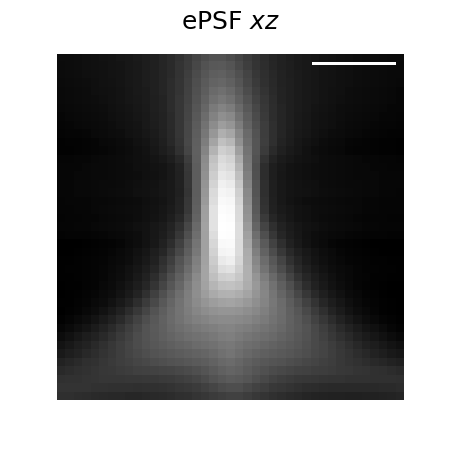

In [14]:
fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(lorentz_PSF_2d, cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("ePSF $x y$")
plt.savefig("lorentz_PSF_xy.svg")
plt.show()


fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(lorentz_PSF_3d.sum(axis=2), cmap="Greys_r")
plt.axis(False)
plt.title("ePSF $x z$")
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("lorentz_PSF_yz.svg")
plt.show()

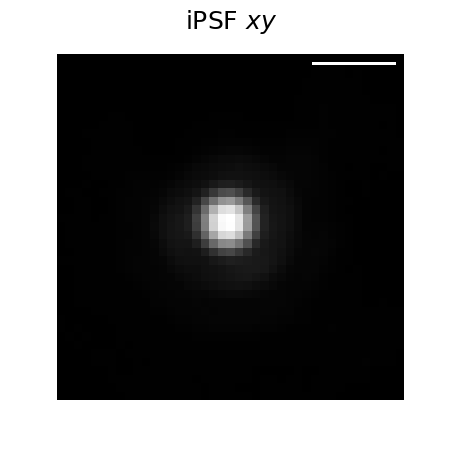

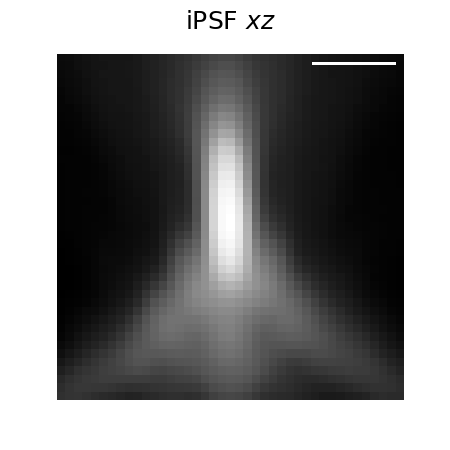

In [15]:
fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(real_PSF[20], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("iPSF $x y$")
plt.savefig("real_PSF_xy.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(real_PSF.sum(axis=1), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.title("iPSF $x z$")
plt.savefig("real_PSF_xz.svg")
plt.show()

In [16]:
def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

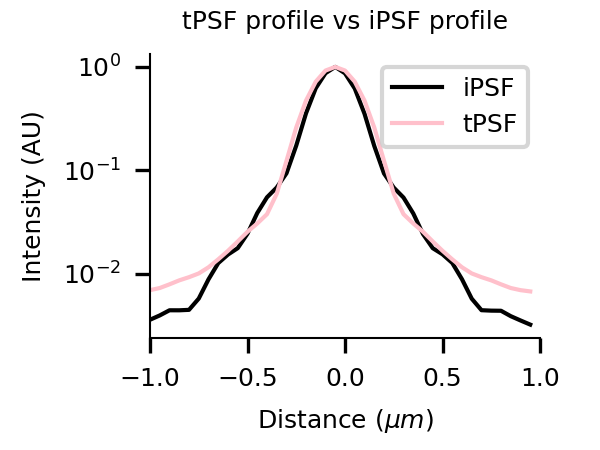

In [17]:

real_PSF_profile = get_midline_rotate_method(real_PSF[real_PSF.shape[0]//2])
theoretical_PSF_profile = my_kernel_xy[0][my_kernel_xy.shape[1]//2]
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 300)
plt.plot(
    np.arange(-len(real_PSF_profile)//2,len(real_PSF_profile)//2)*pix_mic_conv, real_PSF_profile[:]/real_PSF_profile.max(), label = "iPSF", color = "k"
)
plt.plot(
    (np.arange(-len(theoretical_PSF_profile)//2,len(theoretical_PSF_profile)//2))*pix_mic_conv, theoretical_PSF_profile/theoretical_PSF_profile.max(), label = "tPSF", color = "pink"
)

plt.xlim(-1,1)
plt.title("tPSF profile vs iPSF profile")
ax.set_xlabel('Distance ($\mu m$)')
ax.set_ylabel('Intensity (AU)')
plt.legend()
plt.yscale("log")
fig.subplots_adjust(left=0.25, bottom = 0.25)
plt.savefig("synth_kernel_profile.svg")
plt.show()

In [18]:
def get_extrapolated_fit(result, original_fit_xy, parameterised_function):
    real_PSF = get_real_PSF(201)
    x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
    y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
    x, y = xdata_tuple = np.meshgrid(x, y)
    best_fit_result = deepcopy(result)
    best_fit_result[2] = best_fit_result[2] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit_result[1] = best_fit_result[1] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit = parameterised_function(*best_fit_result, (x,y))

    return get_midline_rotate_method(best_fit), get_midline_rotate_method(real_PSF)

def get_real_PSF_mid(PSF_size_xyz):
    pix_mic_conv = 0.05
    real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
    real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
    #real_PSF = gaussian(real_PSF, sigma = 0.75)
    midpoint_xy = real_PSF.shape[1]//2
    
    original_z = real_PSF.shape[0]
    original_xy = real_PSF.shape[1]
    
    max_intensities = real_PSF.max(axis=(1,2))
    peak_intensity_z =  np.argwhere(max_intensities == np.max(max_intensities))[0][0]
    
    
    real_PSF = real_PSF[
        :, # 23 Z stacks total
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1
    ]
    
    real_PSF = real_PSF[peak_intensity_z]
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
    real_PSF = np.clip(real_PSF, 0, np.inf)
    real_PSF = real_PSF / real_PSF.max()
    return real_PSF

In [19]:
import psfmodels as psfm
def PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset):
    synthetic = psfm.make_psf(
        [0],
        nx = 201,
        dxy = 0.065/1.5,
        pz = pz,
        ti0 = ti0,
        ni0 = ni0,
        ni = ni, 
        tg0 = tg0,
        ng0 = ng0,
        ng = ng,
        ns = ns,
        wvl = 0.515,
        NA = NA,
        model = "vectorial"
        ) + offset
    #synthetic -= synthetic.min()
    #synthetic = synthetic / synthetic.max()
    return synthetic



t_PSF_fit_result = good_fit

good_fit_lorentz = [2.207e+00, 2.467e+01 - 4.5, 2.441e+01 - 4.5, 3.893e+00, 3.846e+00, 1.970e+00, 1.326e+00, 6.674e-03, 6.375e-01, 2.458e-01]

x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
x, y = xdata_tuple = np.meshgrid(x, y)

lorentz_PSF_2d = lorentzian_2d_DoG(*good_fit_lorentz, xdata_tuple)

big_real_PSF = get_real_PSF_mid(201)
original_fit_xy = lorentz_PSF_2d.shape[0]
x = np.linspace(0, big_real_PSF.shape[1]-1, big_real_PSF.shape[1])
y = np.linspace(0, big_real_PSF.shape[0]-1, big_real_PSF.shape[0])
x, y = xdata_tuple = np.meshgrid(x, y)
best_fit_result = deepcopy(good_fit_lorentz)
best_fit_result[2] = best_fit_result[2] + big_real_PSF.shape[1]/2 - original_fit_xy/2
best_fit_result[1] = best_fit_result[1] + big_real_PSF.shape[1]/2 - original_fit_xy/2
best_fit = lorentzian_2d_DoG(*best_fit_result, (x,y))
big_PSF_profile = get_midline_rotate_method(big_real_PSF)
big_fit_profile = get_midline_rotate_method(best_fit)

fitted_tPSF_large = PSF_function(*t_PSF_fit_result)
fitted_tPSF_large_profile = get_midline_rotate_method(fitted_tPSF_large[0])





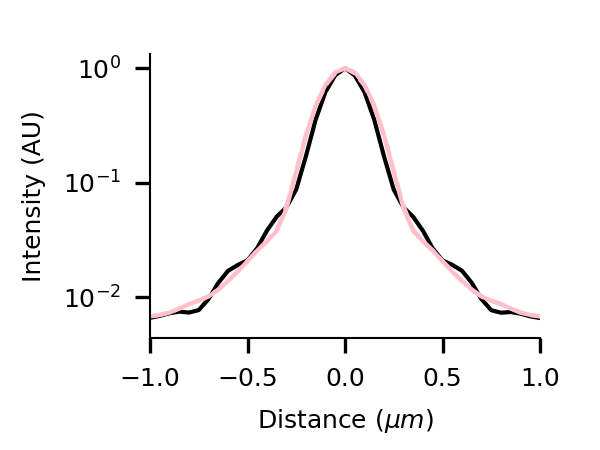

In [20]:



fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 300)

plt.plot(np.arange(-len(big_PSF_profile)//2+1,len(big_PSF_profile)//2+1)*pix_mic_conv, big_PSF_profile/big_PSF_profile.max(), label= "iPSF", color = "k")

plt.plot(np.arange(-len(fitted_tPSF_large_profile)//2+1,len(fitted_tPSF_large_profile)//2+1)*pix_mic_conv, fitted_tPSF_large_profile[::-1]/fitted_tPSF_large_profile.max(), label ="tPSF extrapolation", linestyle = "--", c = "pink")
plt.plot(
    (np.arange(-len(theoretical_PSF_profile)//2+1,len(theoretical_PSF_profile)//2+1))*pix_mic_conv, theoretical_PSF_profile/theoretical_PSF_profile.max(), label = "tPSF fit", color = "pink"
)
plt.xlabel("Distance ($\mu m$)")
ax.set_ylabel('Intensity (AU)')
#plt.legend()
plt.yscale("log")
plt.xlim(-1,1)
plt.ylim(0.004428593334656608, 1.3320082488723777)
fig.subplots_adjust(left=0.25, bottom = 0.25)
plt.savefig("synth_kernel_profile.svg")

plt.show()

In [21]:
fitted_tPSF_large_profile_crop = fitted_tPSF_large_profile[fitted_tPSF_large_profile.shape[0]//2-41//2-1:fitted_tPSF_large_profile.shape[0]//2+41//2]
fitted_tPSF_large_profile_crop.shape

(41,)

In [22]:
big_fit_profile_crop = big_fit_profile[big_fit_profile.shape[0]//2-41//2-1:big_fit_profile.shape[0]//2+41//2]
big_fit_profile_crop.shape

(41,)

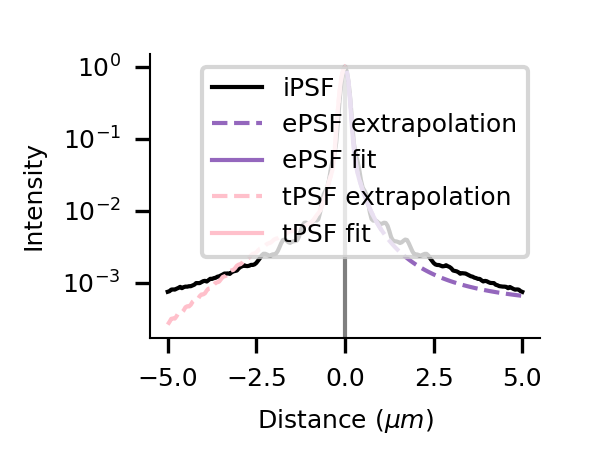

In [23]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 300)

plt.plot([0,0],[0,1], c="tab:grey")

plt.plot(np.arange(-len(big_PSF_profile)//2+1,len(big_PSF_profile)//2+1)*pix_mic_conv, big_PSF_profile/big_PSF_profile.max(), label= "iPSF", color = "k")


ePSF_profile = lorentz_PSF_2d[lorentz_PSF_2d.shape[0]//2]



plt.plot(np.arange(1,len(big_fit_profile)//2+1)*pix_mic_conv, big_fit_profile[::-1][101:]/big_fit_profile.max(), linestyle = "--", label ="ePSF extrapolation", c = "tab:purple")
#plt.plot(np.arange(1,len(ePSF_profile)//2)*pix_mic_conv, ePSF_profile[::-1][ePSF_profile.shape[0]//2+2:]/ePSF_profile.max(), label ="ePSF fit", c = "tab:purple")
plt.plot(np.arange(2,len(big_fit_profile_crop)//2+1)*pix_mic_conv, ePSF_profile[::-1][big_fit_profile_crop.shape[0]//2+2:]/ePSF_profile.max(), label ="ePSF fit", c = "tab:purple")

plt.plot(np.arange(-len(fitted_tPSF_large_profile)//2+1,1)*pix_mic_conv, fitted_tPSF_large_profile[::-1][:fitted_tPSF_large_profile.shape[0]//2+1]/fitted_tPSF_large_profile.max(), label ="tPSF extrapolation", linestyle = "--", c = "pink")


plt.plot(
    (np.arange(-len(theoretical_PSF_profile)//2+1,1))*pix_mic_conv, theoretical_PSF_profile[:theoretical_PSF_profile.shape[0]//2+1]/theoretical_PSF_profile.max(), label = "tPSF fit", color = "pink"
)


#plt.xlim(0,)
plt.xlabel("Distance ($\mu m$)")
ax.set_ylabel('Intensity')
plt.legend()
plt.yscale("log")
fig.subplots_adjust(left=0.25, bottom = 0.25)
plt.savefig("extrapolation.svg")
plt.show()

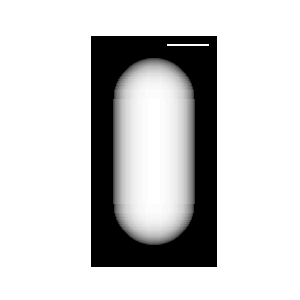

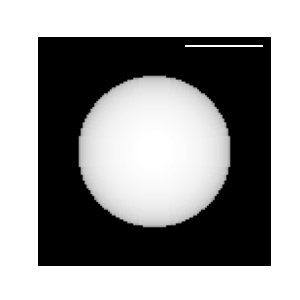

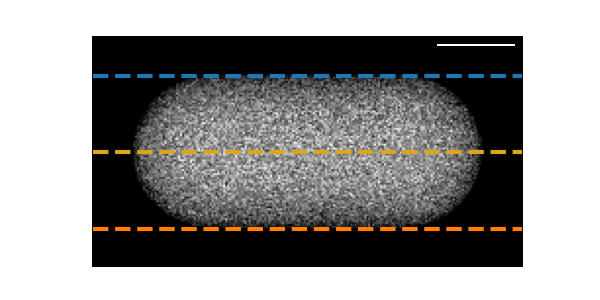

In [170]:
a_cell_high_res = np.pad(convert_to_3D(raster_cell(9/pix_mic_conv, 4/pix_mic_conv, 0)), 20)

coords = np.argwhere(a_cell_high_res)
rng = np.random.default_rng()

conv_cells = []
for molecule_count in [100000]:
    random_coords = rng.choice(coords, molecule_count, replace=False)
    
    empty_cell = np.zeros_like(a_cell_high_res)
    for coord in random_coords:
        empty_cell[coord[0], coord[1], coord[2]] = 1


fig, axs = plt.subplots(1,1, figsize=(1,1), dpi = 300)
plt.imshow(a_cell_high_res.sum(axis=0), cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("cell_xy.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1,1), dpi = 300)
plt.imshow(a_cell_high_res.sum(axis=1), cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("cell_xz.svg")
plt.show()

fig, axs = plt.subplots(1,1, figsize=(2,1), dpi = 300)
img = empty_cell.sum(axis=2)
plt.imshow(img, cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.plot([0,img.shape[1]-1],[20, 20], linestyle = "--")
plt.plot([0,img.shape[1]-1],[img.shape[0]-20, img.shape[0]-20], linestyle = "--")
plt.plot([0,img.shape[1]-1],[img.shape[0]//2, img.shape[0]//2], linestyle = "--", c = "goldenrod")

plt.savefig("cell_yz.svg")
plt.show()

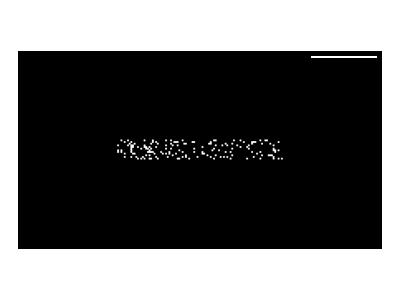

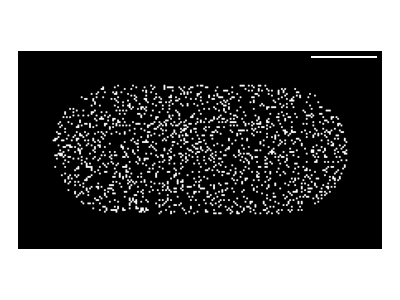

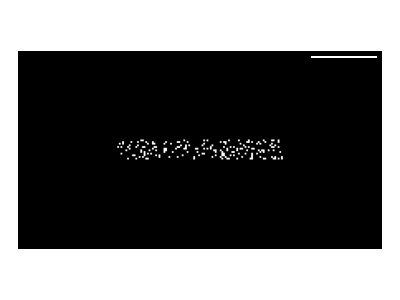

In [191]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(empty_cell[20]), cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  scale_loc="none", box_alpha=0,  color="white", length_fraction=0.25) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_molecules_top.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(empty_cell[empty_cell.shape[0]//2]), cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  scale_loc="none", box_alpha=0,  color="white", length_fraction=0.25) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_molecules_mid.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(empty_cell[empty_cell.shape[0]-21]), cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.025/2, "um", label_loc=None,  scale_loc="none", box_alpha=0,  color="white", length_fraction=0.25) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_molecules_bottom.svg")
plt.show()

In [46]:
from skimage.transform import resize

size: 104


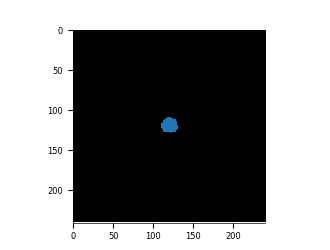

In [161]:
real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag.tif").astype(np.float32)
label_image = cle.voronoi_otsu_labeling(real_PSF)
imshow(label_image, labels=True)
stats = cle.statistics_of_labelled_pixels(real_PSF, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]
pix_mic_conv = 0.05
#real_PSF = np.sum(real_PSF[int(df["mass_center_z"])-10:int(df["mass_center_z"])+10], axis = 0)
real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
real_PSF -= real_PSF.min()
real_PSF = real_PSF / np.sum(real_PSF)

mid_z = int(df["mass_center_z"][0])

a_cell = rescale(empty_cell[20:-20,20:-20,20:-20], 1/4)
a_cell = np.pad(a_cell, 5)
conv_cell = np.array(
    [convolve_rescale(x, y, 1, False) for x, y in zip(
        a_cell.astype(float), real_PSF[mid_z-a_cell.shape[0]//2:mid_z+a_cell.shape[0]//2])
    ]
)


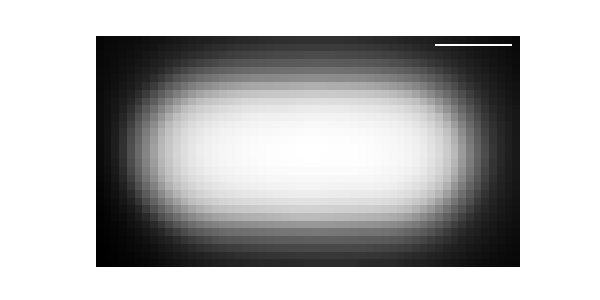

In [171]:
fig, axs = plt.subplots(1,1, figsize=(2,1), dpi = 300)
img = np.rot90(conv_cell.sum(axis=0))
plt.imshow(img, cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(0.5, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.5 micron
axs.add_artist(scalebar)
plt.savefig("cell_conv_projection.svg")


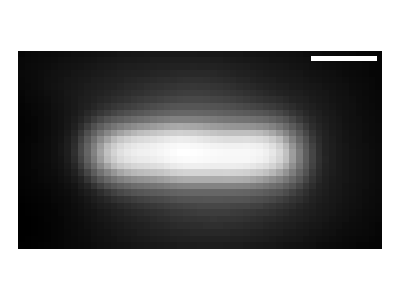

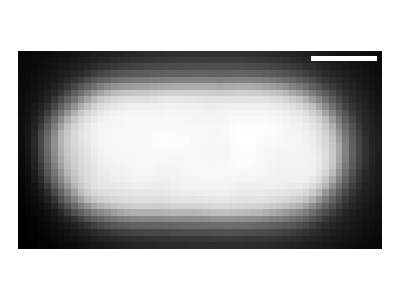

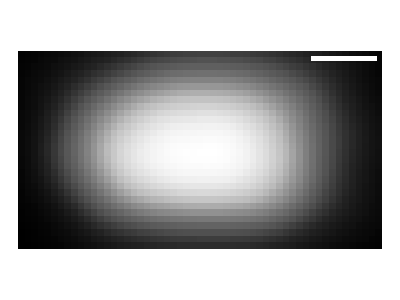

In [150]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(conv_cell[5]), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", width_fraction=0.025, length_fraction=0.2) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_top.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(conv_cell[conv_cell.shape[0]//2]), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white",width_fraction=0.025, length_fraction=0.2) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_mid.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(np.rot90(conv_cell[-6]), cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white",width_fraction=0.025, length_fraction=0.2) # 0.5 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("cell_bottom.svg")
plt.show()

/tmp/ipykernel_204907/1336100241.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  PSF_xz_img = real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2-10:int(df["mass_center_z"])+a_cell.shape[0]//2+10].sum(axis=2)[:,90:-90]


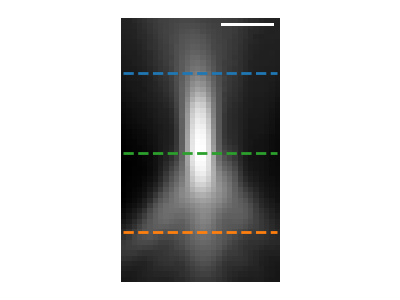

In [151]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
PSF_xz_img = real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2-10:int(df["mass_center_z"])+a_cell.shape[0]//2+10].sum(axis=2)[:,90:-90]
img_z_centre = PSF_xz_img.shape[0]//2
plt.imshow(PSF_xz_img, cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 0.5 micron
ax.add_artist(scalebar)
plt.plot([0,PSF_xz_img.shape[1]-1], [img_z_centre-a_cell.shape[0]//2,img_z_centre-a_cell.shape[0]//2], linestyle="--")
plt.plot([0,PSF_xz_img.shape[1]-1], [img_z_centre+a_cell.shape[0]//2,img_z_centre+a_cell.shape[0]//2], linestyle="--")
plt.plot([0,PSF_xz_img.shape[1]-1], [img_z_centre,img_z_centre], linestyle="--")

plt.tight_layout()
plt.savefig("iPSF_xz.svg")
plt.show()

/tmp/ipykernel_204907/1644845459.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][4][70:-70,70:-70], cmap="Greys_r")


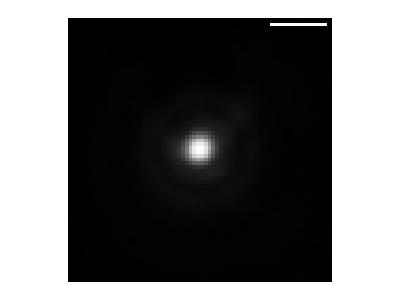

/tmp/ipykernel_204907/1644845459.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][a_cell.shape[0]//2][70:-70,70:-70], cmap="Greys_r")


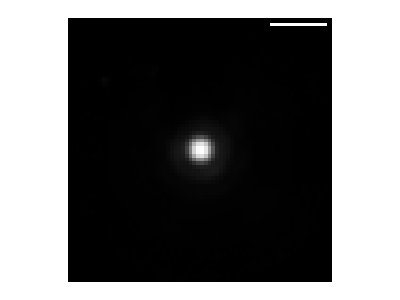

/tmp/ipykernel_204907/1644845459.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][-6][70:-70,70:-70], cmap="Greys_r")


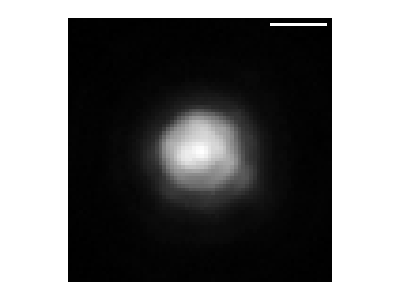

In [152]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][4][70:-70,70:-70], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.75 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("PSF_top.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][a_cell.shape[0]//2][70:-70,70:-70], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.2 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("PSF_mid.svg")
plt.show()
fig, ax = plt.subplots(1,1, figsize=(2,1.5), dpi = 200)
plt.imshow(real_PSF[int(df["mass_center_z"])-a_cell.shape[0]//2:int(df["mass_center_z"])+a_cell.shape[0]//2][-6][70:-70,70:-70], cmap="Greys_r")
plt.axis(False)
scalebar = ScaleBar(pix_mic_conv, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.25) # 0.2 micron
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("PSF_bottom.svg")
plt.show()